In [1]:
%matplotlib inline
from pathlib import Path

import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.cluster import MiniBatchKMeans

In [80]:
data_path = Path('/Users/dlisla/Pictures/bennett_pack-film/Output/_autocrop_jpg/')

image_paths_list = sorted(data_path.glob('*.jpg'))
len(image_paths_list)

21

In [81]:
image_paths_list[:3], image_paths_list[-3:]

([PosixPath('/Users/dlisla/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_024.jpg'),
  PosixPath('/Users/dlisla/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_025.jpg'),
  PosixPath('/Users/dlisla/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_026.jpg')],
 [PosixPath('/Users/dlisla/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_042.jpg'),
  PosixPath('/Users/dlisla/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_043.jpg'),
  PosixPath('/Users/dlisla/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_044.jpg')])

In [82]:
image_path = Path(image_paths_list[-1])

In [83]:
image = cv2.imread(str(image_path))

In [84]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#image_blurred = cv2.GaussianBlur(image_gray, (5, 5), 5)
image_blurred = cv2.bilateralFilter(image_gray, 21, 21, 21)
image_blurred.min()

3

In [85]:
image_gray

array([[236, 236, 236, ..., 235, 235, 235],
       [236, 236, 236, ..., 235, 235, 235],
       [236, 236, 236, ..., 235, 235, 235],
       ...,
       [238, 238, 238, ..., 236, 236, 236],
       [238, 238, 238, ..., 236, 236, 236],
       [238, 238, 238, ..., 236, 236, 236]], dtype=uint8)

In [86]:
image_gray.shape

(800, 1067)

In [87]:
image_blurred.max()

239

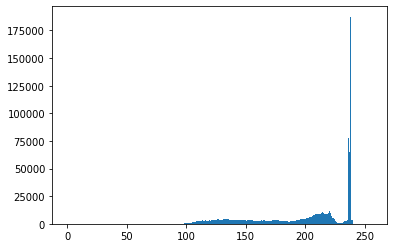

In [88]:
plt.hist(image_blurred.ravel(),256,[0,256]); plt.show()

In [89]:
image_blurred_bgr = cv2.cvtColor(image_blurred, cv2.COLOR_GRAY2BGR)
image_blurred_lab = cv2.cvtColor(image_blurred_bgr, cv2.COLOR_BGR2LAB)

In [90]:
(h, w) = image_blurred_lab.shape[:2]
reshaped = image_blurred_lab.reshape((image_blurred_lab.shape[0] * image_blurred_lab.shape[1], 3))

In [91]:
# apply k-means using the specified number of clusters and
# then create the quantized reshaped based on the predictions
clt = MiniBatchKMeans(n_clusters = 6)
labels = clt.fit_predict(reshaped)
quant = clt.cluster_centers_.astype("uint8")[labels]
 
# reshape the feature vectors to reshapeds
quant = quant.reshape((h, w, 3))
reshape_to_original = reshaped.reshape((h, w, 3))
 
# convert from L*a*b* to RGB
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
image = cv2.cvtColor(reshape_to_original, cv2.COLOR_LAB2BGR)
 
# display the reshapeds and wait for a keypress
# cv2.imshow("quantized", np.hstack([reshaped, quant]))
# cv2.waitKey(0)

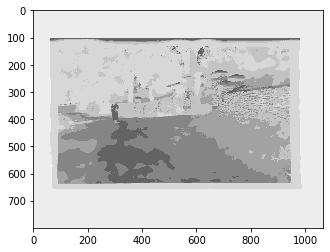

In [92]:
plt.imshow(quant, cmap='gray')

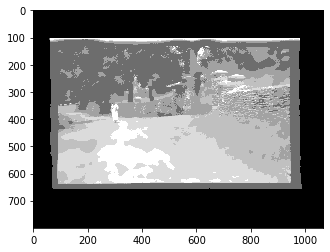

In [93]:
# grayscale and equalize
gray = cv2.cvtColor(quant, cv2.COLOR_BGR2GRAY)
new = cv2.equalizeHist(gray)
new = np.invert(new)
plt.imshow(new, cmap='gray')

In [94]:
np.where(new > 0)

(array([101, 101, 101, ..., 657, 657, 657]),
 array([ 61,  62,  63, ..., 982, 983, 984]))

In [95]:
unique_values = np.unique(new)
print(unique_values)
print(unique_values[1])
threshold_value = (unique_values[1] - 1)
print(f'threshold value is {threshold_value}')

[  0 109 162 192 219 255]
109
threshold value is 108


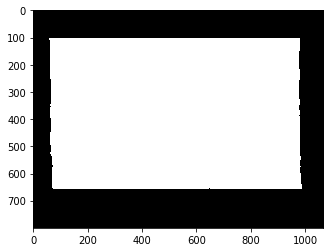

In [98]:
_, thresh = cv2.threshold(new, 2, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

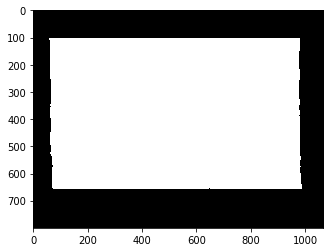

In [99]:
_, thresh = cv2.threshold(new, threshold_value, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

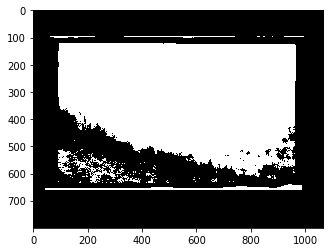

In [25]:
# apply Otsu's automatic thresholding
(T, thresh) = cv2.threshold(image_blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

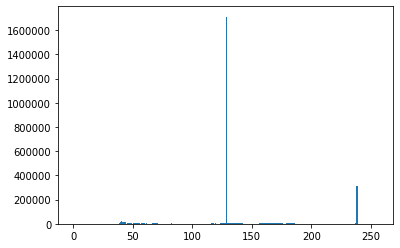

In [26]:
plt.hist(reshaped.ravel(),256,[0,256]); plt.show()

In [27]:
np.mean(image_blurred), np.median(image_blurred)

(152.38029756326148, 159.0)

In [28]:
np.mean(lcc_blurred), np.median(lcc_blurred)

(143.66193767572634, 123.0)

In [29]:
new = cv2.subtract(lcc_gray, image_blurred)

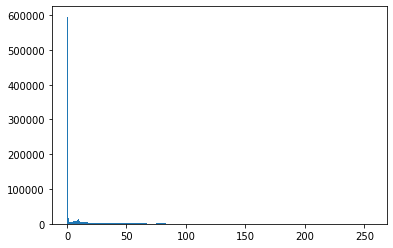

In [30]:
plt.hist(new.ravel(),256,[0,256]); plt.show()

In [31]:
(T, thresh) = cv2.threshold(new, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

In [32]:
T

41.0

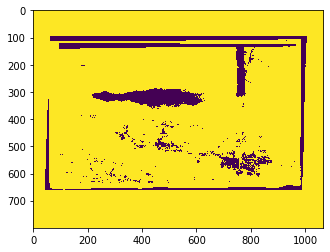

In [33]:
plt.imshow(thresh)

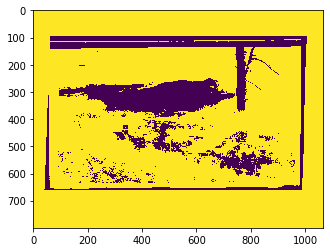

In [34]:
# set a manual threshold
_, thresh = cv2.threshold(new, 15, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh)

In [35]:
for image_path in image_paths_list:
    print(image_path.stem)
    !python autocrop.py {str(image_path)}

MS3892-B2-S11-F35_024
Traceback (most recent call last):
  File "autocrop.py", line 227, in <module>
    capture_one_data_as_str = autocrop(image_path, padding=padding)
  File "autocrop.py", line 160, in autocrop
    rect *= ratio
UnboundLocalError: local variable 'rect' referenced before assignment
MS3892-B2-S11-F35_025
Traceback (most recent call last):
  File "autocrop.py", line 227, in <module>
    capture_one_data_as_str = autocrop(image_path, padding=padding)
  File "autocrop.py", line 160, in autocrop
    rect *= ratio
UnboundLocalError: local variable 'rect' referenced before assignment
MS3892-B2-S11-F35_026
Traceback (most recent call last):
  File "autocrop.py", line 227, in <module>
    capture_one_data_as_str = autocrop(image_path, padding=padding)
  File "autocrop.py", line 160, in autocrop
    rect *= ratio
UnboundLocalError: local variable 'rect' referenced before assignment
MS3892-B2-S11-F35_027
Traceback (most recent call last):
  File "autocrop.py", line 227, in <modu